# **Projet Télédétection Landes - Marion BILLY**

## I - Introduction

Ce projet vise à caractériser la phénologie de différentes strates de végétation (herbacée, landes, arborée) en Bretagne à partir d’une série temporelle Sentinel-2 acquise entre mars et août 2025. Une attention particulière est portée à la signature spectrale des landes afin de les distinguer des autres types de végétation.

Série temporelle Sentinel-2 utilisée: Bretagne 24-25   
- 2025-03-31     
- 2025-04-10	  
- 2025-05-15	  
- 2025-06-17	  
- 2025-07-12	  
- 2025-08-10

Echantillon: PI_strates_bretagne.shp   
Champ strate qui contient les labels numériques des classes:   
- 1	Sol Nu    
- 2	Herbe    
- 3	Landes    
- 4	Arbre  

In [1]:
# import des librairies
import sys
sys.path.append("/home/onyxia/work")
import os
from osgeo import gdal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# personal librairies
from libsigma import read_and_write as rw
from libsigma import classification as cla

Extraction des séries temporelles par bande Sentinel, chaque bande d’un fichier correspondant à une date (même ordre que ci-dessus)

Les images Sentinel-2 sont initialement fournies sous forme de séries temporelles par bande. Afin de faciliter les analyses ultérieures, les bandes ont été regroupées par date pour produire une image multibande Sentinel-2 par date.

In [2]:
base_path = "/home/onyxia/work/data/projet_eval/"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(base_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        # extraire la bande correspondant à la date i
        single_band = arr[:, :, i]
        # s'assurer que c'est 3D pour write_image
        band_arrays.append(np.atleast_3d(single_band))
    
    # concaténer toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)  # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(base_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(base_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Fichier créé pour 2025-03-31 -> /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif
Fichier créé pour 2025-04-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-04-10.tif
Fichier créé pour 2025-05-15 -> /home/onyxia/work/data/projet_eval/bretagne_2025-05-15.tif
Fichier créé pour 2025-06-17 -> /home/onyxia/work/data/projet_eval/bretagne_2025-06-17.tif
Fichier créé pour 2025-07-12 -> /home/onyxia/work/data/projet_eval/bretagne_2025-07-12.tif
Fichier créé pour 2025-08-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-08-10.tif


## II - Analyse des échantillons

### 1. Nombre d'échantillons

In [3]:
gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")
gdf.head()

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


#### Diagramme en bâton du nombre de polygones par classe, diag_baton_nb_poly_by_class.png

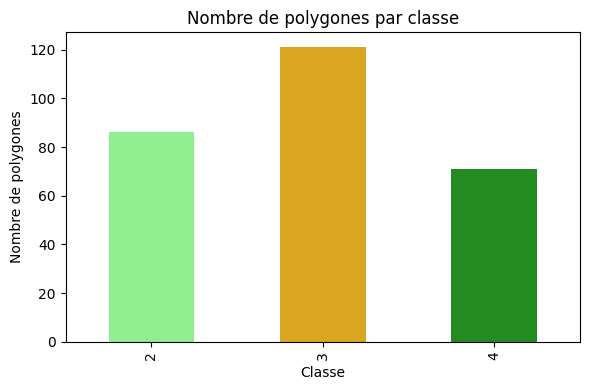

In [4]:
nb_poly = gdf["strate"].value_counts().sort_index()
plt.figure(figsize=(6,4))
colors = ["lightgreen", "goldenrod", "forestgreen"]
nb_poly.plot(kind="bar", color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png", dpi=300)
plt.show()

#### Diagramme en bâton du nombre de pixel par classe, diag_baton_nb_pix_by_class.png

Créer une image d’échantillons en rasterisant le fichier vecteur. L’image créée aura les mêmes dimensions que l’image qu’on cherche à classer ainsi que la même taille de pixel. Une fois cette image obtenue, il est facile d’extraire les valeurs des pixels de l’image qui correspondent aux échantillons à l’aide de Numpy.

Les paramètres spatiaux (résolution et emprise) sont extraits de l’image Sentinel-2 de référence afin de garantir une parfaite correspondance spatiale entre l’image d’échantillons rasterisée et les images utilisées pour la classification.

In [5]:
my_folder = '/home/onyxia/work/data/projet_eval'
ref_image = os.path.join(my_folder, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence

# ouverture de l'image
data_set = rw.open_image(ref_image)

# informations de l'image
nb_lignes, nb_col, _ = rw.get_image_dimension(data_set)
origin_x, origin_y = rw.get_origin_coordinates(data_set)
psize_x, psize_y = rw.get_pixel_size(data_set)
sptial_resolution = abs(psize_x)

# emprise spatiale
xmin = origin_x
xmax = origin_x + nb_col * psize_x
ymax = origin_y
ymin = origin_y + nb_lignes * psize_y

# affichage des paramètres
print("Spatial resolution :", sptial_resolution)
print("Extent :")
print("xmin =", xmin, "ymin =", ymin)
print("xmax =", xmax, "ymax =", ymax)

Spatial resolution : 10.0
Extent :
xmin = 432950.0 ymin = 5362770.0
xmax = 448280.0 ymax = 5368890.0


In [6]:
# define parameters
my_folder = '/home/onyxia/work/data/projet_eval'
in_vector = os.path.join(my_folder, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(my_folder, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.splitext(in_vector)[0] + '_v2.tif'
field_name = 'strate'  # field containing the numeric label of the classes

# define command pattern to fill with paremeters
cmd_pattern = ("gdal_rasterize -a {field_name} "
               "-tr {sptial_resolution} {sptial_resolution} "
               "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
               "{in_vector} {out_image}")

# fill the string with the parameter thanks to format function
cmd = cmd_pattern.format(in_vector=in_vector, xmin=xmin, ymin=ymin, xmax=xmax,
                         ymax=ymax, out_image=out_image, field_name=field_name,
                         sptial_resolution=sptial_resolution)

# execute the command in the terminal
os.system(cmd)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

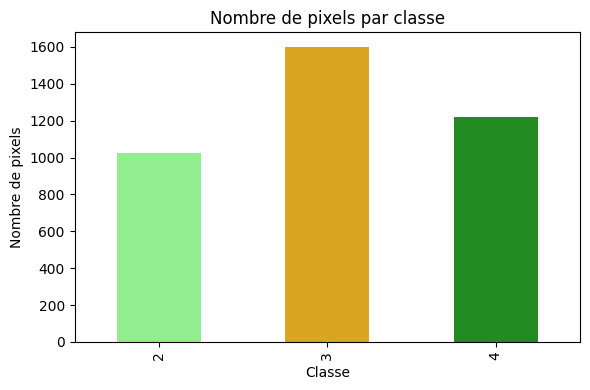

In [7]:
roi_raster = os.path.join(my_folder, 'PI_strates_bretagne_32630_v2.tif')

# get_samples_from_roi renvoie X (valeurs des pixels), Y (labels), t (coordonnées)
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)

# compter le nombre de pixels par classe
classes, counts = np.unique(Y, return_counts=True)
pixel_counts = dict(zip(classes, counts))

# tri par classe
pixel_series = pd.Series(pixel_counts).sort_index()

# Diagramme
plt.figure(figsize=(6,4))
colors = ["lightgreen", "goldenrod", "forestgreen"]
pixel_series.plot(kind="bar", color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png", dpi=300)
plt.show()

### 2. Phénologie des strates, mise en évidence des landes

Reconnaître les signatures spectrales et leur évolution temporelle.

On a la liste des images multibandes par date. (B03 → index 1, B05 → index 3)

Calcul ARI

L’ARI (Anthocyanin Reflectance Index) est utilisé ici comme indicateur de stress ou de sénescence végétale, permettant de mettre en évidence des différences phénologiques entre strates au cours de la saison de croissance.

In [18]:
# dossier de travail
data_dir = "/home/onyxia/work/data/projet_eval"
out_dir = "/home/onyxia/work/results"

dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

ari_list = []

for date in dates:
    filename = os.path.join(data_dir, f"bretagne_{date}.tif")

    # ouverture
    data_set = rw.open_image(filename)
    img = rw.load_img_as_array(filename)

    # bandes nécessaires
    b03 = img[:, :, 1].astype("float32")
    b05 = img[:, :, 3].astype("float32")

    # masque pixels valides, éviter divisions par zéro
    mask_valid = (b03 > 0) & (b05 > 0)

    # tableau ARI initialisé avec NoData
    ari = np.full(b03.shape, -9999, dtype="float32")

    # calcul ARI uniquement sur pixels valides
    ari[mask_valid] = (
        (1.0 / b03[mask_valid] - 1.0 / b05[mask_valid]) /
        (1.0 / b03[mask_valid] + 1.0 / b05[mask_valid])
    )

    # ajout à la liste pour empilement temporel
    ari_list.append(ari[:, :, np.newaxis])


Empilement temporel

In [19]:
ari_serie_temp = np.concatenate(ari_list, axis=2)

out_filename = os.path.join(out_dir, "ARI_serie_temp.tif")

rw.write_image(
    out_filename,
    ari_serie_temp,
    data_set=data_set,
    gdal_dtype=gdal.GDT_Float32,
)

Graphique série temporelle, moyenne et écarts types

In [20]:

# get_samples_from_roi renvoie X (valeurs ARI), Y (labels), t (coordonnées)
X_samples, Y_samples, _ = cla.get_samples_from_roi("/home/onyxia/work/results/ARI_serie_temp.tif", roi_raster)

# X_samples : valeurs ARI pour les pixels d'échantillons (n_pixels, n_dates)
# Y_samples : labels des strates correspondants (n_pixels,)

# convertir en DataFrame
df = pd.DataFrame(X_samples, columns=dates)
df['strate'] = Y_samples.flatten()

# remplacer NoData par NaN
df.replace(-9999, np.nan, inplace=True)

# moyenne et écart-type par strate
grouped = df.groupby('strate')
mean_df = grouped.mean()
std_df = grouped.std()



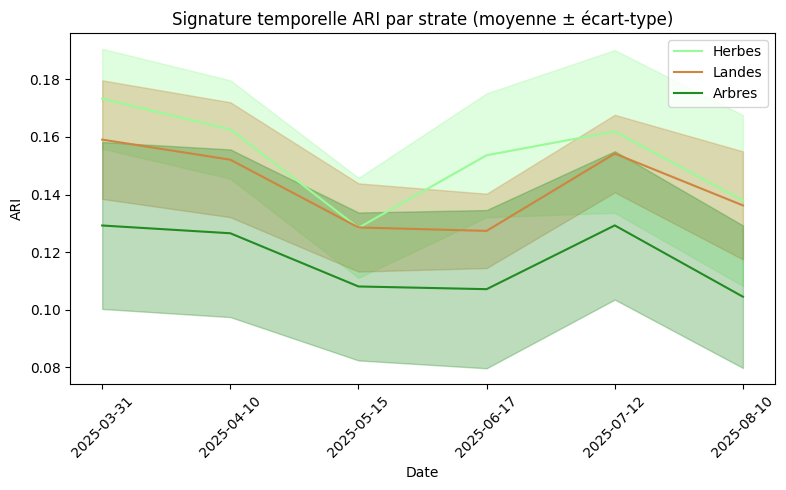

In [21]:
# couleurs et labels pour les strates
colors = {2: 'palegreen', 3: 'peru', 4: 'forestgreen'}
labels_name = {2: 'Herbes', 3: 'Landes', 4: 'Arbres'}

fig, ax = plt.subplots(figsize=(8,5))

for strate in mean_df.index:
    means = mean_df.loc[strate].values
    stds = std_df.loc[strate].values
    ax.plot(range(len(dates)), means, color=colors[strate], label=labels_name[strate])
    ax.fill_between(
        range(len(dates)),
        means - stds,
        means + stds,
        color=colors[strate],
        alpha=0.3
    )

ax.set_xticks(range(len(dates)))
ax.set_xticklabels(dates, rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("ARI")
ax.set_title("Signature temporelle ARI par strate (moyenne ± écart-type)")
ax.legend()
plt.tight_layout()

fig_dir = os.path.join(out_dir, "figure")
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, "ARI_signature_by_strate.png"), dpi=300)
plt.show()




Si la courbe des landesest distincte dans le temps des autres strates, surtout à certaines dates (ex. pic automnal dû aux anthocyanes), alors on peut dire que le ARI permet de distinguer la lande.

Sinon, elle se confond avec d’autres classes et ARI seul ne suffit pas.

### 3. Production d’une d’essence forestière à l’échelle du pixel